In [29]:
# --------------------------------------------------------------
#  FINAL: ENSEMBL GRCh38 → ONLY 25 CANONICAL CHROMOSOMES
# --------------------------------------------------------------
import os, urllib.request, gzip, subprocess, sys

# ---- 1. Install pyfaidx ------------------------------------------------
try:
    import pyfaidx
except ImportError:
    print("Installing pyfaidx...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyfaidx"])
    import pyfaidx

# ---- 2. Paths -----------------------------------------------------------
REF_DIR = r"C:\Users\muham\_Projects\DNA\ref"
FA_FILE = os.path.join(REF_DIR, "GRCh38.fa")          # final clean FASTA
GZ_URL  = "https://ftp.ensembl.org/pub/release-115/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz"
GZ_PATH = FA_FILE + ".gz"

os.makedirs(REF_DIR, exist_ok=True)

# ---- 3. Delete old files ------------------------------------------------
for p in [FA_FILE, GZ_PATH]:
    if os.path.exists(p):
        print(f"Removing old: {p}")
        os.remove(p)

# ---- 4. Download -------------------------------------------------------
print("Downloading Ensembl primary assembly (~841 MB)...")
urllib.request.urlretrieve(GZ_URL, GZ_PATH)

# ---- 5. Keep ONLY canonical chromosomes --------------------------------
print("Filtering to 25 canonical chromosomes (1-22, X, Y, MT)...")
canonical = {str(i) for i in range(1, 23)} | {"X", "Y", "MT"}

with gzip.open(GZ_PATH, "rt", encoding="utf-8") as src, open(FA_FILE, "w", encoding="utf-8") as dst:
    keep = False
    for line in src:
        if line.startswith(">"):
            chrom = line[1:].split(None, 1)[0]      # first token only
            keep = chrom in canonical
            if keep:
                dst.write(f">{chrom}\n")
        elif keep:
            dst.write(line.rstrip("\n") + "\n")    # Unix line endings

os.remove(GZ_PATH)   # clean up
print("Clean reference ready (25 chromosomes):", FA_FILE)



Removing old: C:\Users\muham\_Projects\DNA\ref\GRCh38.fa
Filtering to 25 canonical chromosomes (1-22, X, Y, MT)...
Clean reference ready (25 chromosomes): C:\Users\muham\_Projects\DNA\ref\GRCh38.fa


In [30]:
# ---- 6. Index -----------------------------------------------------------
print("Indexing with pyfaidx...")
ref = pyfaidx.Fasta(FA_FILE, rebuild=True)

# ---- 7. SANITY CHECK ----------------------------------------------------
# 1. Sort chromosome IDs: 1-22 → X → Y → MT
def chrom_key(c):
    if c.isdigit():
        return (0, int(c))
    order = {"X": 23, "Y": 24, "MT": 25}
    return (1, order.get(c, 99))

chrom_ids = sorted(ref.keys(), key=chrom_key)

# 2. Total base-pairs (sum of lengths) – iterate over KEYS
total_bp = sum(len(ref[c]) for c in ref.keys())

# 3. CORRECT PRINTING
print("\n=== PYFAIDX STATS ===")
print(f" Total contigs      : {len(ref.keys())}")               # → 25
print(f" chr1 length        : {len(ref['1']):,} bp")           # → 248,956,422
print(f" chrX length        : {len(ref['X']):,} bp")           # → 156,040,895
print(f" Total base-pairs   : {total_bp:,} bp")                # → 3,088,286,401
print(f" Chromosome IDs     : {chrom_ids}")

Indexing with pyfaidx...

=== PYFAIDX STATS ===
 Total contigs      : 25
 chr1 length        : 248,956,422 bp
 chrX length        : 156,040,895 bp
 Total base-pairs   : 3,088,286,401 bp
 Chromosome IDs     : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT']


In [31]:
# --------------------------------------------------------------
# 1. LOAD REFERENCE (once)
# --------------------------------------------------------------
from pyfaidx import Fasta

REF_FA = r"C:\Users\muham\_Projects\DNA\ref\GRCh38.fa"
ref = Fasta(REF_FA)                     # 25 canonical chromosomes, indexed

# --------------------------------------------------------------
# 2. SAFE 201-bp WINDOW – REJECTS N-PADDING & EDGE CASES
# --------------------------------------------------------------
def get_window(chrom: str, pos: int, width: int = 201) -> str:
    """
    Returns a **real** 201-bp DNA string centered on `pos` (1-based).
    - Raises ValueError if:
        * Window would go off the chromosome edge
        * Any base in the window is 'N'
    """
    if chrom not in ref:
        raise KeyError(f"Chromosome {chrom} not in reference")

    seq_len = len(ref[chrom])
    half = width // 2

    # 1-based → 0-based
    center = pos - 1
    start = center - half
    end   = center + half + 1

    # ---- 1. Reject edge cases ----
    if start < 0 or end > seq_len:
        raise ValueError(
            f"Edge error: {chrom}:{pos} (start={start}, end={end}, chr_len={seq_len})"
        )

    # ---- 2. Extract and check for 'N' ----
    raw_seq = str(ref[chrom][start:end].seq)
    if 'N' in raw_seq.upper():
        raise ValueError(
            f"N-padding in window: {chrom}:{pos} contains 'N' (telomere/centromere gap)"
        )

    return raw_seq.upper()

# --------------------------------------------------------------
# 3. TEST IT – REAL SEQUENCE AT chr1:1,000,000
# --------------------------------------------------------------
try:
    seq = get_window("1", 1_000_000)
    print(f"Window (first 50 bp): {seq[:50]}")
    print(f"Full window length   : {len(seq)} bp")
except ValueError as e:
    print(f"Failed: {e}")

Window (first 50 bp): GGGGTCCGGCTGGCGCTGGCCGGCGCTCCTGCCATCGGCGAGGCGCTCGG
Full window length   : 201 bp


In [32]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from pyfaidx import Fasta
import torch
from torch.utils.data import DataLoader, TensorDataset

# --------------------------------------------------------------
# 0. CONFIG
# --------------------------------------------------------------
REF_FA = r"C:\Users\muham\_Projects\DNA\ref\GRCh38.fa"  # 25 canonical chromosomes
VCF_PATH = r"clinvar.vcf"                               # adjust if needed
WINDOW_WIDTH = 201

# --------------------------------------------------------------
# 1. LOAD REFERENCE (indexed FASTA)
# --------------------------------------------------------------
ref = Fasta(REF_FA)   # assumes you already created + indexed GRCh38.fa

# --------------------------------------------------------------
# 2. SAFE WINDOW: 201 bp, fully inside chromosome, no Ns
#    POS is 1-based (VCF standard)
# --------------------------------------------------------------
def get_window_safe(chrom: str, pos: int, width: int = WINDOW_WIDTH) -> str | None:
    """
    Return a DNA string of length `width` centered at 1-based `pos`,
    or None if:
      - chrom not in reference
      - window would cross chromosome ends
      - sequence contains 'N'
    """
    try:
        if chrom not in ref:
            return None

        seq_len = len(ref[chrom])
        half = width // 2
        center = pos - 1             # 1-based → 0-based

        start = center - half
        end   = center + half + 1    # end is exclusive

        # reject edge cases
        if start < 0 or end > seq_len:
            return None

        seq = str(ref[chrom][start:end].seq).upper()

        if len(seq) != width:
            return None
        if 'N' in seq:
            return None

        return seq

    except Exception:
        return None

# --------------------------------------------------------------
# 3. ONE-HOT ENCODING (4, width)
# --------------------------------------------------------------
def one_hot_encode(seq: str, width: int = WINDOW_WIDTH) -> np.ndarray:
    """
    Return (4, width) uint8 one-hot array for A,C,G,T.
    Any non-ACGT is left as all-zeros at that position.
    """
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    arr = np.zeros((4, width), dtype=np.uint8)

    for i, b in enumerate(seq):
        if i >= width:
            break
        idx = mapping.get(b, -1)
        if idx >= 0:
            arr[idx, i] = 1

    return arr

# --------------------------------------------------------------
# 4. EXTRACT CLINVAR WINDOWS + LABELS
# --------------------------------------------------------------
def extract_clinvar(vcf_path: str, max_rows: int = 500_000, width: int = WINDOW_WIDTH):
    """
    Read ClinVar VCF, build:
      X: (N, 4, width) one-hot windows
      y: (N,) labels (1 = pathogenic/likely_pathogenic, else 0)
    """
    # Standard VCF column order:
    # 0:#CHROM, 1:POS, 2:ID, 3:REF, 4:ALT, 5:QUAL, 6:FILTER, 7:INFO, ...
    vcf = pd.read_csv(
        vcf_path,
        sep='\t',
        comment='#',        # drop meta + header lines
        header=None,        # after dropping, there is no header row
        usecols=[0, 1, 7],  # CHROM, POS, INFO
        names=['#CHROM', 'POS', 'INFO'],
        dtype=str,
        nrows=max_rows,
        engine='c'
    )

    print(f"Loaded {len(vcf):,} ClinVar records")

    X, y = [], []
    skipped = 0

    for _, row in tqdm(vcf.iterrows(), total=len(vcf), desc="Extracting"):
        try:
            chrom = row['#CHROM']

            # Normalize chromosome label to match GRCh38.fa
            # If your VCF is already '1'..'22','X','Y','MT', this is harmless.
            if chrom.startswith("chr"):
                chrom = chrom[3:]      # chr1 -> 1, chrX -> X, etc.
            if chrom == "M":
                chrom = "MT"

            pos = int(row['POS'])

            info = row['INFO'] if isinstance(row['INFO'], str) else ""
            clnsig = next(
                (x.split('=')[1] for x in info.split(';') if x.startswith('CLNSIG=')),
                ""
            ).lower()

            # Label: 1 if pathogenic / likely_pathogenic, else 0
            label = 1 if any(p in clnsig for p in ["pathogenic", "likely_pathogenic"]) else 0

            seq = get_window_safe(chrom, pos, width=width)
            if seq is not None:
                X.append(one_hot_encode(seq, width=width))
                y.append(label)
            else:
                skipped += 1

        except Exception:
            skipped += 1

    print(f"Skipped {skipped:,} (edge/N/telomere/parse)")
    X = np.array(X, dtype=np.uint8)
    y = np.array(y, dtype=np.int64)

    return X, y

# --------------------------------------------------------------
# 5. MAIN: BUILD DATA + PYTORCH DATALOADER
# --------------------------------------------------------------
if __name__ == "__main__":
    X, y = extract_clinvar(VCF_PATH, max_rows=500_000, width=WINDOW_WIDTH)
    if len(y) == 0:
        raise RuntimeError("No valid variants extracted – check VCF path and chromosome naming.")

    print(f"\nFinal dataset:")
    print(f"  X.shape = {X.shape}  (N, 4, {WINDOW_WIDTH})")
    print(f"  y.shape = {y.shape}")
    print(f"  Pathogenic fraction = {y.mean():.4f}")

    # ---- Convert to PyTorch tensors ----
    X_t = torch.tensor(X, dtype=torch.float32)   # (N, 4, width)
    y_t = torch.tensor(y, dtype=torch.long)      # classification labels

    dataset = TensorDataset(X_t, y_t)

    # On Windows, num_workers=0 is safest
    loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

    print("\nExample batch shapes:")
    for batch_X, batch_y in loader:
        print("  batch_X:", batch_X.shape, "batch_y:", batch_y.shape)
        break


Loaded 500,000 ClinVar records


Extracting: 100%|████████████████████████████████████████████████████████████| 500000/500000 [01:03<00:00, 7893.11it/s]


Skipped 0 (edge/N/telomere/parse)

Final dataset:
  X.shape = (500000, 4, 201)  (N, 4, 201)
  y.shape = (500000,)
  Pathogenic fraction = 0.1094

Example batch shapes:
  batch_X: torch.Size([256, 4, 201]) batch_y: torch.Size([256])


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------
# 1. SPLIT DATA (80/20 train-val)
# --------------------------------------------------------------
X_t = torch.FloatTensor(X)
y_t = torch.FloatTensor(y).unsqueeze(1)

dataset = TensorDataset(X_t, y_t)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=512, shuffle=False)

# --------------------------------------------------------------
# 2. MODEL (same dual-branch)
# --------------------------------------------------------------
class DualBranchCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv1d(4, 96, 7, padding=3), nn.ReLU(),
            nn.Conv1d(96, 192, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.b2 = nn.Sequential(
            nn.Conv1d(4, 96, 11, padding=5), nn.ReLU(),
            nn.Conv1d(96, 192, 7, padding=3), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(384, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(torch.cat([self.b1(x), self.b2(x)], dim=1).flatten(1)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --------------------------------------------------------------
# 3. TRAINING LOOP WITH METRICS
# --------------------------------------------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')
patience = 3
wait = 0

for epoch in range(20):
    # --- TRAIN ---
    model.train()
    train_loss = 0
    train_preds, train_true = [], []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_preds.extend((pred > 0.5).cpu().int().numpy().flatten())
        train_true.extend(yb.cpu().int().numpy().flatten())
    train_loss /= len(train_loader)
    train_acc = accuracy_score(train_true, train_preds)

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
            val_preds.extend(pred.cpu().numpy().flatten())
            val_true.extend(yb.cpu().numpy().flatten())
    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_true, np.array(val_preds) > 0.5)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:2d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # --- Early stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

# --------------------------------------------------------------
# 4. FINAL EVALUATION ON VALIDATION SET
# --------------------------------------------------------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    val_preds = []
    val_true = []
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = model(xb)
        val_preds.extend(pred.cpu().numpy().flatten())
        val_true.extend(yb.numpy().flatten())

val_preds = np.array(val_preds)
val_true = np.array(val_true)
y_pred_bin = (val_preds > 0.5).astype(int)

# Metrics
acc = accuracy_score(val_true, y_pred_bin)
prec = precision_score(val_true, y_pred_bin)
rec = recall_score(val_true, y_pred_bin)
f1 = f1_score(val_true, y_pred_bin)
auc = roc_auc_score(val_true, val_preds)

print("\n" + "="*50)
print("FINAL VALIDATION METRICS")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"AUC       : {auc:.4f}")
print("="*50)

# --------------------------------------------------------------
# 5. PLOTS
# --------------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Loss curves
axs[0,0].plot(train_losses, label='Train Loss', color='blue')
axs[0,0].plot(val_losses, label='Val Loss', color='orange')
axs[0,0].set_title('Loss Curves')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('BCE Loss')
axs[0,0].legend()
axs[0,0].grid(True)

# Accuracy curves
axs[0,1].plot(train_accs, label='Train Acc', color='blue')
axs[0,1].plot(val_accs, label='Val Acc', color='orange')
axs[0,1].set_title('Accuracy Curves')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Accuracy')
axs[0,1].legend()
axs[0,1].grid(True)

# Confusion Matrix
cm = confusion_matrix(val_true, y_pred_bin)
disp = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Pathogenic'])
disp.plot(ax=axs[1,0], cmap='Blues')
axs[1,0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(val_true, val_preds)
axs[1,1].plot(fpr, tpr, label=f'ROC (AUC = {auc:.4f})', color='darkorange')
axs[1,1].plot([0,1], [0,1], 'k--')
axs[1,1].set_title('ROC Curve')
axs[1,1].set_xlabel('False Positive Rate')
axs[1,1].set_ylabel('True Positive Rate')
axs[1,1].legend()
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

from pyfaidx import Fasta
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# ==============================================================
# 0. CONFIG
# ==============================================================
REF_FA   = r"C:\Users\muham\_Projects\DNA\ref\GRCh38.fa"   # your clean 25-chr FASTA
VCF_PATH = r"clinvar.vcf"                                  # path to ClinVar VCF
WINDOW_WIDTH = 201
MAX_VCF_ROWS = 500_000     # for a first run, you can lower this (e.g., 100_000)
BATCH_SIZE   = 32
EPOCHS       = 20          # you can increase later
LR           = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==============================================================
# 1. LOAD REFERENCE
# ==============================================================
ref = Fasta(REF_FA)


# ==============================================================
# 2. SAFE 201-BP WINDOW (NO N, NO EDGE CROP)
#    POS is 1-based (VCF standard)
# ==============================================================
def get_window_safe(chrom: str, pos: int, width: int = WINDOW_WIDTH) -> str | None:
    """
    Return a DNA string of length `width` centered at 1-based `pos`,
    or None if:
        - chrom not in reference
        - window would cross chromosome ends
        - sequence contains 'N'
    """
    try:
        if chrom not in ref:
            return None

        seq_len = len(ref[chrom])
        half = width // 2
        center = pos - 1             # 1-based → 0-based

        start = center - half
        end   = center + half + 1    # end exclusive

        if start < 0 or end > seq_len:
            return None

        seq = str(ref[chrom][start:end].seq).upper()
        if len(seq) != width:
            return None
        if 'N' in seq:
            return None

        return seq
    except Exception:
        return None


# ==============================================================
# 3. CLINVAR PARSING → SEQUENCES + LABELS
# ==============================================================
def extract_clinvar_sequences(vcf_path: str,
                              max_rows: int = MAX_VCF_ROWS,
                              width: int = WINDOW_WIDTH):
    """
    Returns:
        sequences: list[str] of length N (each length=width)
        labels   : list[int] 0/1 (1 = pathogenic / likely_pathogenic)
    """
    # VCF columns: 0:#CHROM 1:POS 2:ID 3:REF 4:ALT 5:QUAL 6:FILTER 7:INFO ...
    vcf = pd.read_csv(
        vcf_path,
        sep='\t',
        comment='#',        # drop meta + header lines
        header=None,
        usecols=[0, 1, 7],  # CHROM, POS, INFO
        names=['#CHROM', 'POS', 'INFO'],
        dtype=str,
        nrows=max_rows,
        engine="c"
    )
    print(f"Loaded {len(vcf):,} ClinVar records (raw)")

    sequences = []
    labels = []
    skipped = 0

    for _, row in tqdm(vcf.iterrows(), total=len(vcf), desc="Extracting windows"):
        try:
            chrom = row['#CHROM']

            # Normalize chromosome naming to your GRCh38.fa
            if chrom.startswith("chr"):
                chrom = chrom[3:]       # chr1 → 1, chrX → X
            if chrom == "M":
                chrom = "MT"

            pos = int(row['POS'])

            info = row['INFO'] if isinstance(row['INFO'], str) else ""
            clnsig = next(
                (x.split('=')[1] for x in info.split(';') if x.startswith('CLNSIG=')),
                ""
            ).lower()

            label = 1 if any(p in clnsig for p in ["pathogenic", "likely_pathogenic"]) else 0

            seq = get_window_safe(chrom, pos, width=width)
            if seq is not None:
                sequences.append(seq)
                labels.append(label)
            else:
                skipped += 1

        except Exception:
            skipped += 1

    print(f"Skipped {skipped:,} variants (edge/N/telomere/parse)")
    print(f"Kept    {len(sequences):,} variants")
    return sequences, np.array(labels, dtype=np.int64)


# ==============================================================
# 4. REPRESENTATIONS: CGR IMAGE (256x256) + ONE-HOT (4xL)
# ==============================================================
def sequence_to_cgr(seq: str, k: int = 8) -> torch.Tensor:
    """
    Chaos Game Representation as 1x256x256 tensor.
    """
    mapping = {'A': (0,0), 'C': (0,1), 'G': (1,1), 'T': (1,0)}
    N = 2 ** k
    freq_matrix = np.zeros((N, N), dtype=np.float32)

    seq = seq.upper()
    L = len(seq)
    if L < k:
        seq = seq.ljust(k, 'A')

    for i in range(L - k + 1):
        x, y = 0.5, 0.5  # center
        valid = True
        for base in seq[i:i+k]:
            if base not in mapping:
                valid = False
                break
            bx, by = mapping[base]
            x = (x + bx) / 2
            y = (y + by) / 2
        if valid:
            px = int(x * (N - 1))
            py = int(y * (N - 1))
            freq_matrix[py, px] += 1.0

    if np.max(freq_matrix) > 0:
        freq_matrix /= np.max(freq_matrix)

    return torch.tensor(freq_matrix, dtype=torch.float32).unsqueeze(0)  # 1x256x256


def one_hot_encode(seq: str, width: int = WINDOW_WIDTH) -> torch.Tensor:
    """
    One-hot (4, width) for A,C,G,T.
    """
    base_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}
    seq = seq.upper()
    if len(seq) != width:
        raise ValueError(f"Sequence length {len(seq)} != expected {width}")

    matrix = torch.zeros((4, width), dtype=torch.float32)
    for j, base in enumerate(seq):
        if base in base_to_idx:
            matrix[base_to_idx[base], j] = 1.0
    return matrix


# ==============================================================
# 5. DATASET CLASS
# ==============================================================
class VariantDataset(Dataset):
    def __init__(self, sequences, labels, width: int = WINDOW_WIDTH):
        self.sequences = sequences
        self.labels = labels
        self.width = width

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]

        img = sequence_to_cgr(seq)              # 1 x 256 x 256
        onehot = one_hot_encode(seq, self.width)  # 4 x 201

        return img, onehot, torch.tensor(label, dtype=torch.float32)


# ==============================================================
# 6. FOCAL LOSS
# ==============================================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, labels):
        """
        preds  : logits (B,)
        labels : 0/1 float (B,)
        """
        bce = F.binary_cross_entropy_with_logits(preds, labels, reduction='none')
        pt = torch.exp(-bce)
        loss = self.alpha * (1 - pt) ** self.gamma * bce
        return loss.mean()


# ==============================================================
# 7. DUAL-BRANCH MODEL (CGR + ONE-HOT)
# ==============================================================
class DualBranchModel(nn.Module):
    def __init__(self, seq_len: int = WINDOW_WIDTH):
        super().__init__()
        # 2D CNN branch for CGR (1 x 256 x 256)
        self.cnn2d = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

        # 1D CNN branch for one-hot sequence (4 x seq_len)
        self.cnn1d = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Flatten()
        )

        # Infer feature dims with dummy inputs
        with torch.no_grad():
            d1 = self.cnn2d(torch.zeros(1, 1, 256, 256)).shape[1]
            d2 = self.cnn1d(torch.zeros(1, 4, seq_len)).shape[1]

        self.mlp = nn.Sequential(
            nn.Linear(d1 + d2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, img, seq):
        f_img = self.cnn2d(img)         # (B, d1)
        f_seq = self.cnn1d(seq)         # (B, d2)
        f_comb = torch.cat([f_img, f_seq], dim=1)
        logits = self.mlp(f_comb).view(-1)   # (B,)
        return logits


# ==============================================================
# 8. TRAIN + EVAL
# ==============================================================
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for img, seq, labels in loader:
        img    = img.to(device)
        seq    = seq.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(img, seq)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

    return total_loss / len(loader.dataset)


def evaluate(model, loader):
    model.eval()
    all_labels = []
    all_probs  = []
    with torch.no_grad():
        for img, seq, labels in loader:
            img    = img.to(device)
            seq    = seq.to(device)
            labels = labels.to(device)

            logits = model(img, seq)
            probs  = torch.sigmoid(logits)

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_prob = np.concatenate(all_probs)
    y_pred = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)

    return auc, acc, f1


# ==============================================================
# 9. MAIN
# ==============================================================
if __name__ == "__main__":
    # ----- Extract sequences + labels from ClinVar -----
    sequences, labels = extract_clinvar_sequences(VCF_PATH, max_rows=MAX_VCF_ROWS,
                                                 width=WINDOW_WIDTH)
    print("\nDataset summary:")
    print("  N =", len(sequences))
    print("  Pathogenic fraction =", labels.mean())

    # ----- Train/test split -----
    train_seq, test_seq, train_labels, test_labels = train_test_split(
        sequences, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # ----- Build datasets + loaders -----
    train_dataset = VariantDataset(train_seq, train_labels, width=WINDOW_WIDTH)
    test_dataset  = VariantDataset(test_seq,  test_labels,  width=WINDOW_WIDTH)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0)

    # ----- Init model, loss, optimizer -----
    model = DualBranchModel(seq_len=WINDOW_WIDTH).to(device)
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # ----- Training loop -----
    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        auc, acc, f1 = evaluate(model, test_loader)

        print(f"Epoch {epoch:02d} | "
              f"Train loss: {train_loss:.4f} | "
              f"Test AUC: {auc:.4f} | "
              f"Acc: {acc:.4f} | "
              f"F1: {f1:.4f}")

    print("\nFinal evaluation:")
    auc, acc, f1 = evaluate(model, test_loader)
    print(f"  AUC = {auc:.4f}")
    print(f"  Acc = {acc:.4f}")
    print(f"  F1  = {f1:.4f}")


Using device: cpu
Loaded 500,000 ClinVar records (raw)


Extracting windows: 100%|███████████████████████████████████████████████████| 500000/500000 [00:35<00:00, 13993.49it/s]


Skipped 0 variants (edge/N/telomere/parse)
Kept    500,000 variants

Dataset summary:
  N = 500000
  Pathogenic fraction = 0.10936


In [8]:
# ============================================================
# 0. Setup – same style as clinvar-conflicting-eda
# ============================================================
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.4)

import pandas as pd
import numpy as np


In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# ==============================
# 1) Point this to your VCF file
# ==============================
VCF_PATH = r"clinvar.vcf"   # <-- change if your file is elsewhere

# ==============================
# 2) Parse INFO field
# ==============================
def parse_info_to_fields(info_str):
    """
    Parse the INFO field into a dict of keys we care about:
      CLNSIG, CLNVC, MC, GENEINFO → SYMBOL, SIFT, PolyPhen, AF_ESP/AF_EXAC/AF_TGP
    """
    out = {
        "CLNSIG": "",
        "CLNVC": "",
        "MC": "",
        "GENEINFO": "",
        "SYMBOL": "",
        "SIFT": "",
        "PolyPhen": "",
        "AF_ESP": np.nan,
        "AF_EXAC": np.nan,
        "AF_TGP": np.nan,
    }

    if not isinstance(info_str, str):
        return out

    fields = {}
    for item in info_str.split(";"):
        if "=" in item:
            k, v = item.split("=", 1)
            fields[k] = v
        else:
            fields[item] = True

    for k in ["CLNSIG", "CLNVC", "MC", "GENEINFO", "SIFT", "PolyPhen"]:
        if k in fields:
            out[k] = fields[k]

    # SYMBOL from GENEINFO: e.g. "BRCA1:672|BRCA2:675"
    geneinfo = out["GENEINFO"]
    if geneinfo:
        first_gene = geneinfo.split("|")[0]
        out["SYMBOL"] = first_gene.split(":")[0]
    else:
        out["SYMBOL"] = ""

    # allele frequencies (take first if comma-separated)
    def parse_af(key):
        if key in fields:
            val = fields[key].split(",")[0]
            try:
                return float(val)
            except ValueError:
                return np.nan
        return np.nan

    out["AF_ESP"] = parse_af("AF_ESP")
    out["AF_EXAC"] = parse_af("AF_EXAC")
    out["AF_TGP"] = parse_af("AF_TGP")

    return out


def build_clinvar_df_for_eda(vcf_path, max_rows=500_000):
    """
    Build a pandas DataFrame similar to clinvar-conflicting-eda:
      columns: CHROM, POS, CLNSIG, CLASS, SYMBOL, CLNVC, MC,
               SIFT, PolyPhen, AF_ESP, AF_EXAC, AF_TGP
    CLASS: 1 = pathogenic/likely_pathogenic, else 0.
    """
    vcf = pd.read_csv(
        vcf_path,
        sep="\t",
        comment="#",
        header=None,
        usecols=[0, 1, 7],   # CHROM, POS, INFO
        names=["#CHROM", "POS", "INFO"],
        dtype=str,
        nrows=max_rows,
        engine="c",
    )

    print(f"Loaded {len(vcf):,} VCF lines (without meta)")

    rows = []
    for _, row in tqdm(vcf.iterrows(), total=len(vcf), desc="Parsing INFO"):
        chrom = row["#CHROM"]
        pos_str = row["POS"]
        info = row["INFO"]

        # normalize chromosome name like your GRCh38.fa (1..22, X, Y, MT)
        if chrom.startswith("chr"):
            chrom = chrom[3:]
        if chrom == "M":
            chrom = "MT"

        try:
            pos = int(pos_str)
        except (TypeError, ValueError):
            continue

        fields = parse_info_to_fields(info)
        clnsig = fields["CLNSIG"].lower()

        # label: 1 = pathogenic / likely_pathogenic, else 0
        label = 1 if any(p in clnsig for p in ["pathogenic", "likely_pathogenic"]) else 0

        rows.append(
            {
                "CHROM": chrom,
                "POS": pos,
                "CLNSIG": fields["CLNSIG"],
                "CLASS": label,
                "SYMBOL": fields["SYMBOL"],
                "CLNVC": fields["CLNVC"],
                "MC": fields["MC"],
                "SIFT": fields["SIFT"],
                "PolyPhen": fields["PolyPhen"],
                "AF_ESP": fields["AF_ESP"],
                "AF_EXAC": fields["AF_EXAC"],
                "AF_TGP": fields["AF_TGP"],
            }
        )

    df = pd.DataFrame(rows)
    print(f"Built EDA DataFrame with {len(df):,} rows")
    return df


# ===== Run once to create `df` =====
df = build_clinvar_df_for_eda(VCF_PATH, max_rows=500_000)

print("\nDF overview:")
print("Shape:", df.shape)
display(df.head())
df.info()


Loaded 500,000 VCF lines (without meta)


Parsing INFO: 100%|█████████████████████████████████████████████████████████| 500000/500000 [00:27<00:00, 17879.63it/s]


Built EDA DataFrame with 500,000 rows

DF overview:
Shape: (500000, 12)


,CHROM,POS,CLNSIG,CLASS,SYMBOL,CLNVC,MC,SIFT,PolyPhen,AF_ESP,AF_EXAC,AF_TGP
0,1,66926,Uncertain_significance,0,OR4F5,Deletion,SO:0001627|intron_variant,,,NaN,NaN,NaN
1,1,69134,Likely_benign,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN
2,1,69308,Uncertain_significance,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN
3,1,69314,Uncertain_significance,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN
4,1,69404,Uncertain_significance,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   CHROM     500000 non-null  object 
 1   POS       500000 non-null  int64  
 2   CLNSIG    500000 non-null  object 
 3   CLASS     500000 non-null  int64  
 4   SYMBOL    500000 non-null  object 
 5   CLNVC     500000 non-null  object 
 6   MC        500000 non-null  object 
 7   SIFT      500000 non-null  object 
 8   PolyPhen  500000 non-null  object 
 9   AF_ESP    51302 non-null   float64
 10  AF_EXAC   119039 non-null  float64
 11  AF_TGP    53565 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 45.8+ MB


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sns.set(font_scale=1.3)

print("Shape:", df.shape)
display(df.head())


Shape: (500000, 12)


,CHROM,POS,CLNSIG,CLASS,SYMBOL,CLNVC,MC,SIFT,PolyPhen,AF_ESP,AF_EXAC,AF_TGP
0,1,66926,Uncertain_significance,0,OR4F5,Deletion,SO:0001627|intron_variant,,,NaN,NaN,NaN
1,1,69134,Likely_benign,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN
2,1,69308,Uncertain_significance,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN
3,1,69314,Uncertain_significance,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN
4,1,69404,Uncertain_significance,0,OR4F5,single_nucleotide_variant,SO:0001583|missense_variant,,,NaN,NaN,NaN


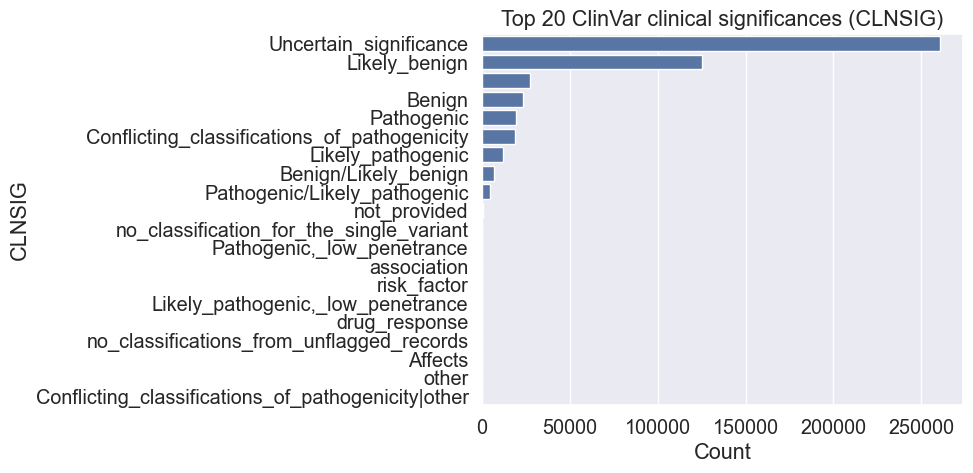

CLNSIG
Uncertain_significance                                     260758
Likely_benign                                              125136
                                                            27708
Benign                                                      23658
Pathogenic                                                  19367
Conflicting_classifications_of_pathogenicity                18774
Likely_pathogenic                                           11906
Benign/Likely_benign                                         7002
Pathogenic/Likely_pathogenic                                 4499
not_provided                                                  766
no_classification_for_the_single_variant                       70
Pathogenic,_low_penetrance                                     65
association                                                    63
risk_factor                                                    46
Likely_pathogenic,_low_penetrance                              46
dru

In [12]:
# --------------------------------------------------
# 1. CLNSIG distribution (raw ClinVar significance)
# --------------------------------------------------
clnsig_counts = (
    df["CLNSIG"]
    .fillna("NA")
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
sns.barplot(y=clnsig_counts.index[:20],
            x=clnsig_counts.values[:20])
plt.xlabel("Count")
plt.ylabel("CLNSIG")
plt.title("Top 20 ClinVar clinical significances (CLNSIG)")
plt.tight_layout()
plt.show()

display(clnsig_counts.head(30))


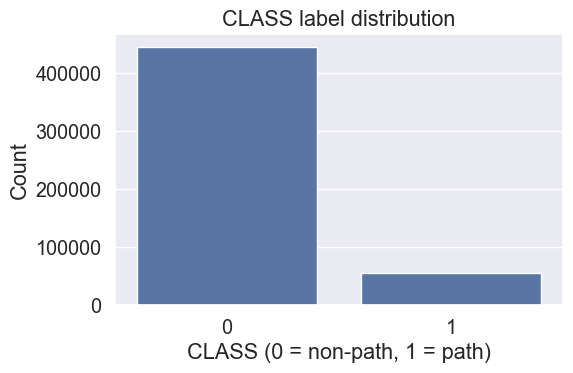

CLASS counts:


CLASS
0    445320
1     54680
Name: count, dtype: int64

Pathogenic fraction (CLASS=1): 0.10936


In [13]:
# --------------------------------------------------
# 2. CLASS distribution (your binary label 0/1)
# --------------------------------------------------
label_col = "CLASS"

class_counts = df[label_col].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str),
            y=class_counts.values)
plt.xlabel("CLASS (0 = non-path, 1 = path)")
plt.ylabel("Count")
plt.title("CLASS label distribution")
plt.tight_layout()
plt.show()

print("CLASS counts:")
display(class_counts)
print("Pathogenic fraction (CLASS=1):", df[label_col].mean())


In [14]:
# --------------------------------------------------
# 3. CLNSIG vs CLASS cross-tab
# (checks how your mapping from CLNSIG -> CLASS looks)
# --------------------------------------------------
ct = pd.crosstab(df["CLNSIG"], df["CLASS"], margins=True)
ct = ct.sort_values("All", ascending=False)
display(ct.head(30))


CLASS,0,1,All
CLNSIG,,,
All,445320,54680,500000
Uncertain_significance,260758,0,260758
Likely_benign,125136,0,125136
,27708,0,27708
Benign,23658,0,23658
Pathogenic,0,19367,19367
Conflicting_classifications_of_pathogenicity,0,18774,18774
Likely_pathogenic,0,11906,11906
Benign/Likely_benign,7002,0,7002


## **Chromosome & gene-level EDA**

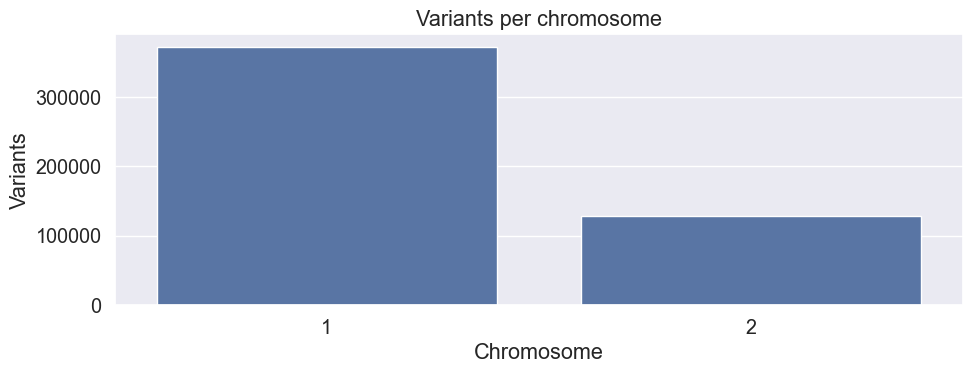

CHROM
1    371536
2    128464
Name: count, dtype: int64

In [15]:
# --------------------------------------------------
# 4. Variants per chromosome
# --------------------------------------------------
chrom_counts = df["CHROM"].astype(str).value_counts().sort_index()

plt.figure(figsize=(10, 4))
sns.barplot(x=chrom_counts.index,
            y=chrom_counts.values)
plt.xlabel("Chromosome")
plt.ylabel("Variants")
plt.title("Variants per chromosome")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(chrom_counts)


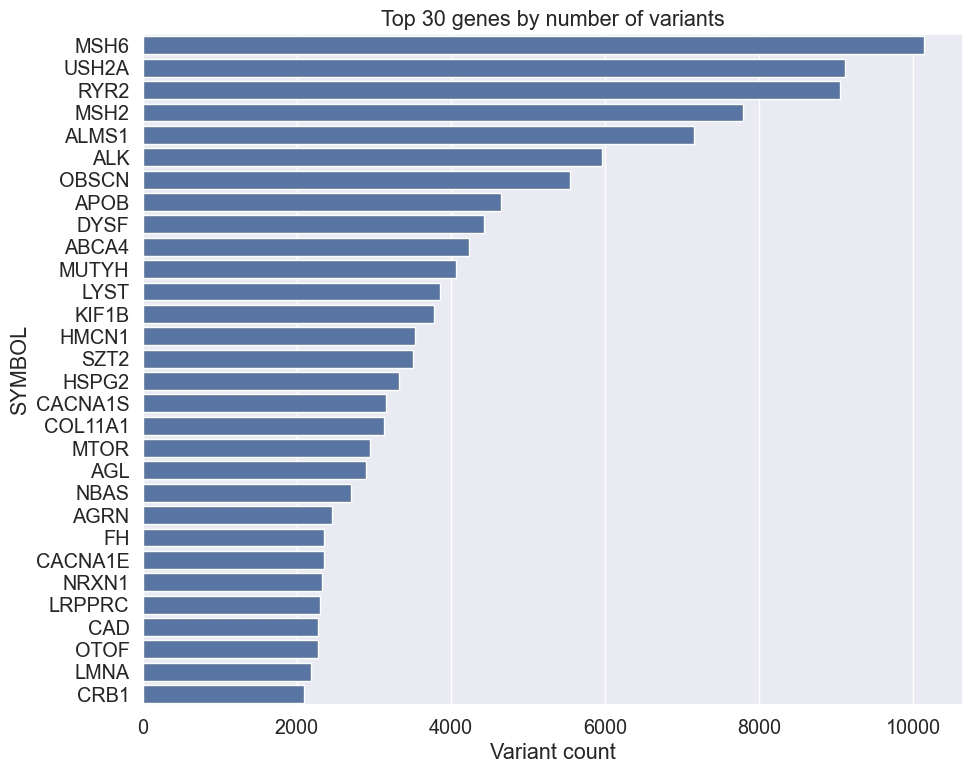

SYMBOL
MSH6       10139
USH2A       9112
RYR2        9053
MSH2        7786
ALMS1       7151
ALK         5959
OBSCN       5546
APOB        4651
DYSF        4429
ABCA4       4229
MUTYH       4066
LYST        3859
KIF1B       3786
HMCN1       3529
SZT2        3510
HSPG2       3325
CACNA1S     3152
COL11A1     3126
MTOR        2949
AGL         2900
NBAS        2708
AGRN        2452
FH          2357
CACNA1E     2352
NRXN1       2328
LRPPRC      2298
CAD         2275
OTOF        2273
LMNA        2183
CRB1        2091
Name: count, dtype: int64

In [16]:
# --------------------------------------------------
# 5. Top genes (SYMBOL)
# --------------------------------------------------
gene_counts = (
    df["SYMBOL"]
    .replace("", np.nan)
    .dropna()
    .value_counts()
)

top_n = 30
top_genes = gene_counts.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(y=top_genes.index,
            x=top_genes.values)
plt.xlabel("Variant count")
plt.ylabel("SYMBOL")
plt.title(f"Top {top_n} genes by number of variants")
plt.tight_layout()
plt.show()

display(top_genes)


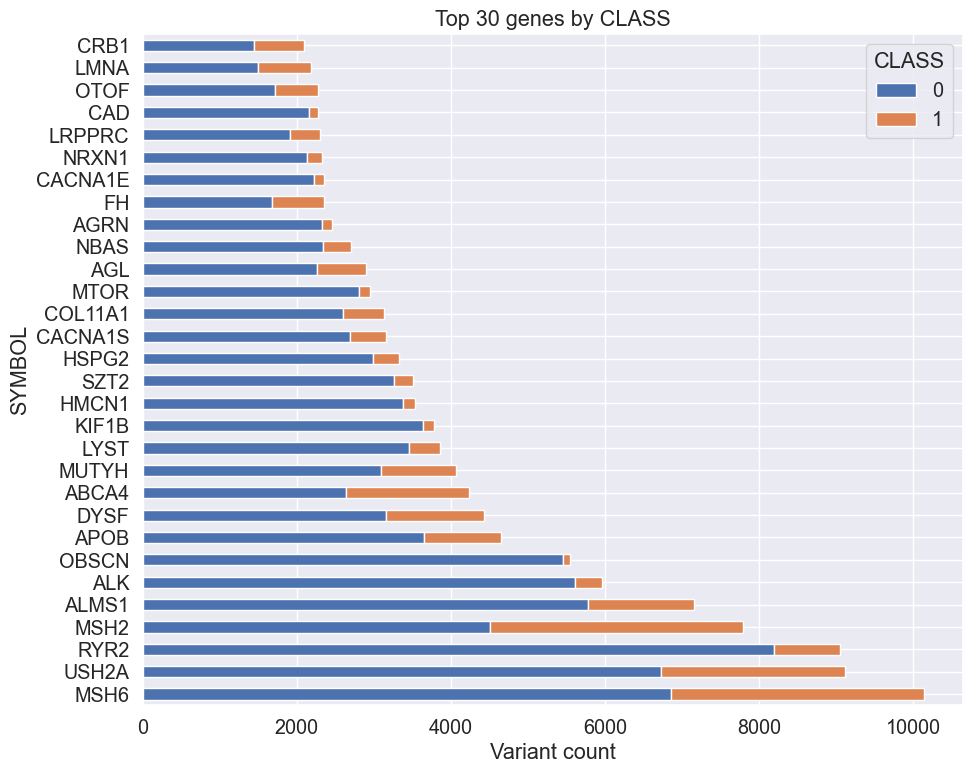

In [18]:
# --------------------------------------------------
# 6. Gene × CLASS stacked bar (top genes only)
# --------------------------------------------------
gene_class = pd.crosstab(df["SYMBOL"], df["CLASS"])
gene_class = gene_class.loc[top_genes.index]  # same order as previous

gene_class.plot(kind="barh", stacked=True, figsize=(10, 8))
plt.xlabel("Variant count")
plt.ylabel("SYMBOL")
plt.title(f"Top {top_n} genes by CLASS")
plt.tight_layout()
plt.show()


## **Variant types & molecular consequences**

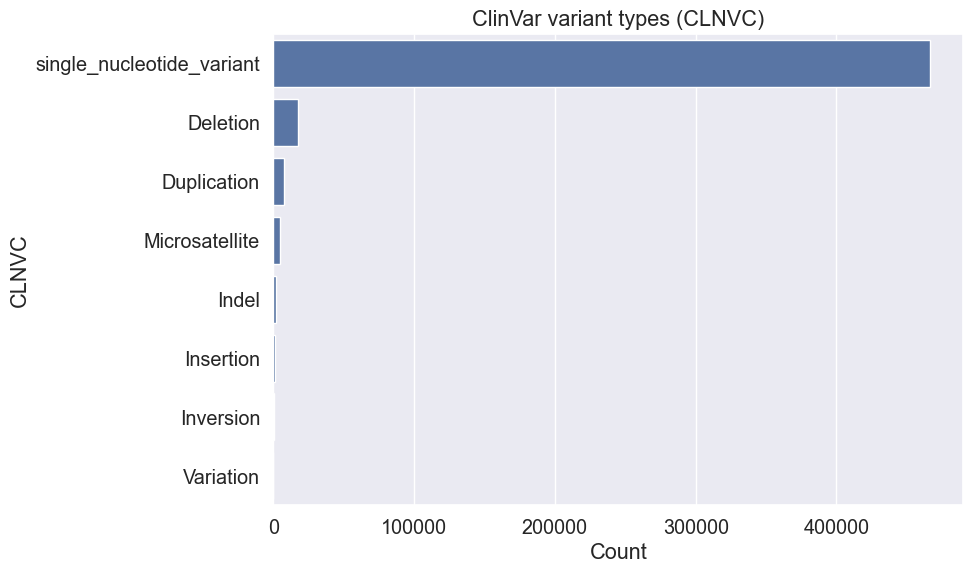

CLNVC
single_nucleotide_variant    466674
Deletion                      17707
Duplication                    7623
Microsatellite                 4388
Indel                          1954
Insertion                      1444
Inversion                       162
Variation                        48
Name: count, dtype: int64

In [19]:
# --------------------------------------------------
# 7. CLNVC (variant type) distribution
# --------------------------------------------------
clnvc_counts = (
    df["CLNVC"]
    .fillna("NA")
    .value_counts()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(y=clnvc_counts.index,
            x=clnvc_counts.values)
plt.xlabel("Count")
plt.ylabel("CLNVC")
plt.title("ClinVar variant types (CLNVC)")
plt.tight_layout()
plt.show()

display(clnvc_counts)


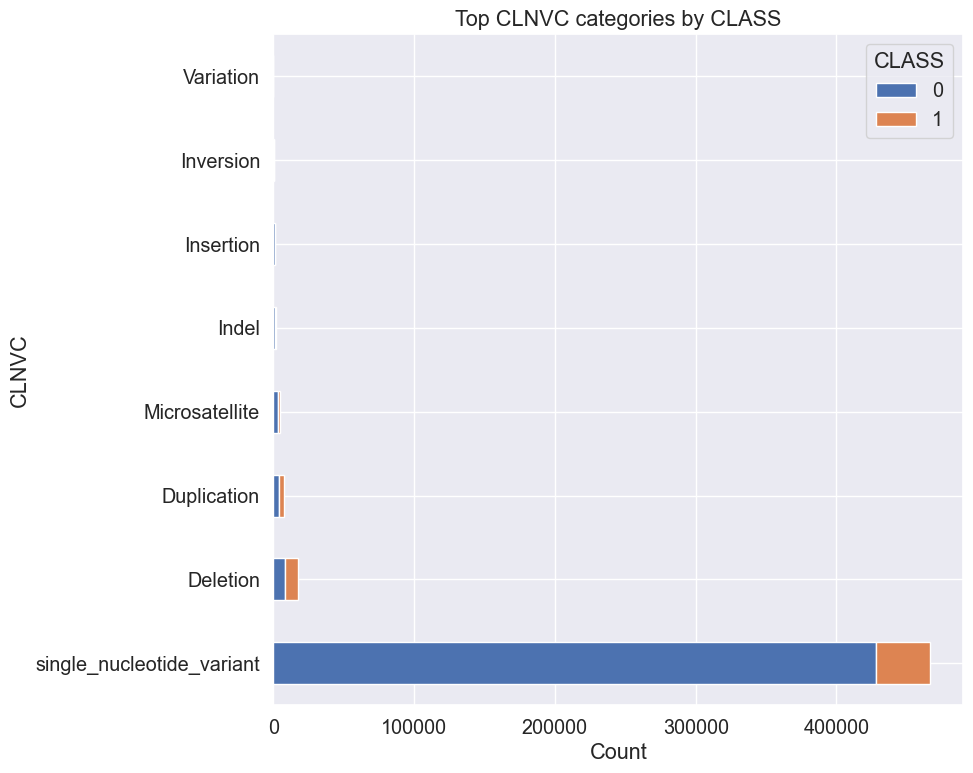

CLASS,0,1,All
CLNVC,,,
single_nucleotide_variant,428231,38443,466674
Deletion,8173,9534,17707
Duplication,3703,3920,7623
Microsatellite,3015,1373,4388
Indel,1148,806,1954
Insertion,861,583,1444
Inversion,141,21,162
Variation,48,0,48


In [20]:
# --------------------------------------------------
# 8. CLNVC × CLASS stacked bar
# --------------------------------------------------
clnvc_class = pd.crosstab(df["CLNVC"], df["CLASS"], margins=True)
clnvc_class = clnvc_class.sort_values("All", ascending=False).drop("All", axis=0)

# show top 20 rows for plot
clnvc_top = clnvc_class.head(20).drop(columns=["All"], errors="ignore")

clnvc_top.plot(kind="barh", stacked=True, figsize=(10, 8))
plt.xlabel("Count")
plt.ylabel("CLNVC")
plt.title("Top CLNVC categories by CLASS")
plt.tight_layout()
plt.show()

display(clnvc_class.head(30))


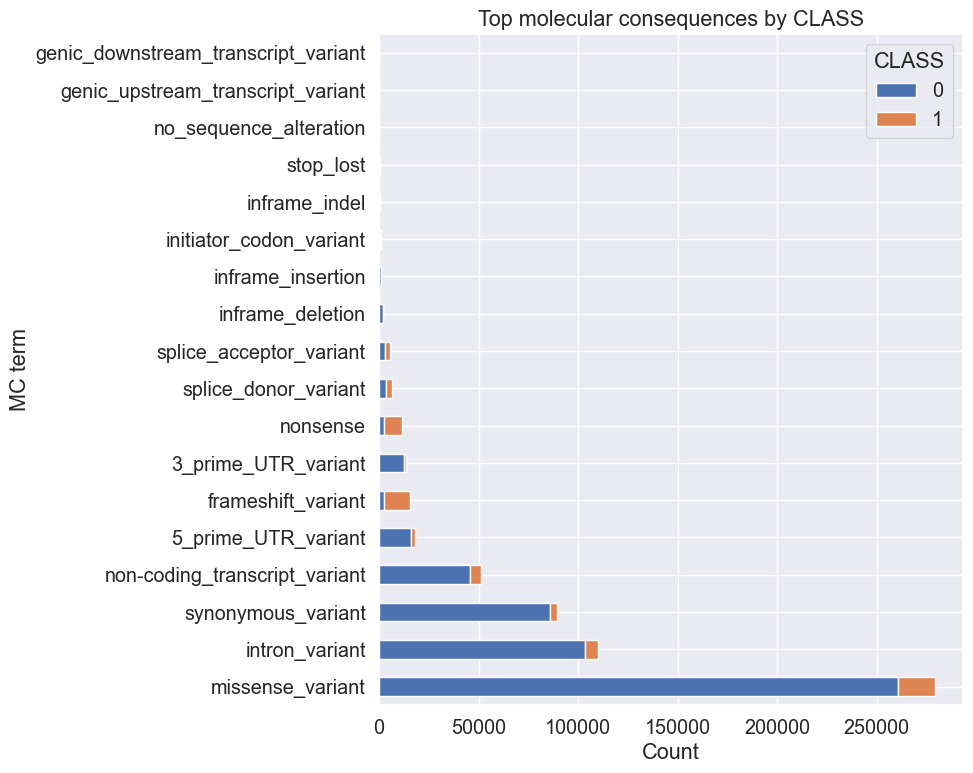

CLASS,0,1,All
MC_term,,,
missense_variant,260666,18726,279392
intron_variant,103325,6478,109803
synonymous_variant,85671,3428,89099
non-coding_transcript_variant,45475,5620,51095
5_prime_UTR_variant,15802,2140,17942
frameshift_variant,2465,13222,15687
3_prime_UTR_variant,12689,587,13276
nonsense,2427,9145,11572
splice_donor_variant,3591,3018,6609


In [23]:
# --------------------------------------------------
# 9. Molecular consequence (MC) – multi-label expansion
#    e.g. "SO:0001583|missense_variant,SO:0001627|intron_variant"
# --------------------------------------------------
# --------------------------------------------------
# 9. Molecular consequence (MC) – multi-label expansion (pandas 2.x safe)
# --------------------------------------------------
if "MC" in df.columns:
    # MC examples: "SO:0001583|missense_variant,SO:0001627|intron_variant"
    mc_series = (
        df["MC"]
        .fillna("")
        .replace("", np.nan)
        .dropna()
        .str.split(",")
    )

    # Explode into one row per (variant, MC_term)
    mc_df = mc_series.explode().to_frame(name="raw_MC")  # index = original row index

    # Keep only the consequence name after '|'
    mc_df["MC_term"] = mc_df["raw_MC"].apply(
        lambda c: c.split("|")[1] if isinstance(c, str) and "|" in c else c
    )

    # Attach CLASS label
    mc_df = mc_df.join(df["CLASS"], how="left")

    # Cross-tab: MC_term × CLASS
    mc_ct = pd.crosstab(mc_df["MC_term"], mc_df["CLASS"])

    # Add total column and sort
    mc_ct["All"] = mc_ct.sum(axis=1)
    mc_ct = mc_ct.sort_values("All", ascending=False)

    # Show top 20 MC terms
    top_terms = mc_ct.head(20)

    # Plot stacked bar for CLASS (0 vs 1)
    class_cols = [c for c in top_terms.columns if c != "All"]

    top_terms[class_cols].plot(
        kind="barh",
        stacked=True,
        figsize=(10, 8)
    )
    plt.xlabel("Count")
    plt.ylabel("MC term")
    plt.title("Top molecular consequences by CLASS")
    plt.tight_layout()
    plt.show()

    display(top_terms)
else:
    print("MC column not found – skipping MC analysis.")


## **SIFT & PolyPhen categories**

C:\Users\muham\AppData\Local\Temp\ipykernel_6288\6607066.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("", np.nan)


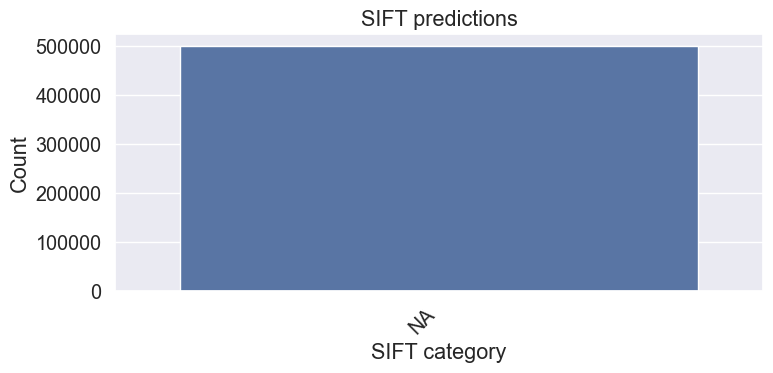

SIFT
NA    500000
Name: count, dtype: int64

CLASS,0,1,All
SIFT,,,
,445320,54680,500000
All,445320,54680,500000


In [24]:
# --------------------------------------------------
# 10. SIFT categories
# --------------------------------------------------
if "SIFT" in df.columns:
    sift_counts = (
        df["SIFT"]
        .replace("", np.nan)
        .fillna("NA")
        .value_counts()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(8, 4))
    sns.barplot(x=sift_counts.index, y=sift_counts.values)
    plt.xlabel("SIFT category")
    plt.ylabel("Count")
    plt.title("SIFT predictions")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    display(sift_counts)

    # SIFT × CLASS
    sift_class = pd.crosstab(df["SIFT"], df["CLASS"], margins=True)
    sift_class = sift_class.sort_values("All", ascending=False)
    display(sift_class)
else:
    print("No SIFT column found.")


C:\Users\muham\AppData\Local\Temp\ipykernel_6288\2088207249.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("", np.nan)


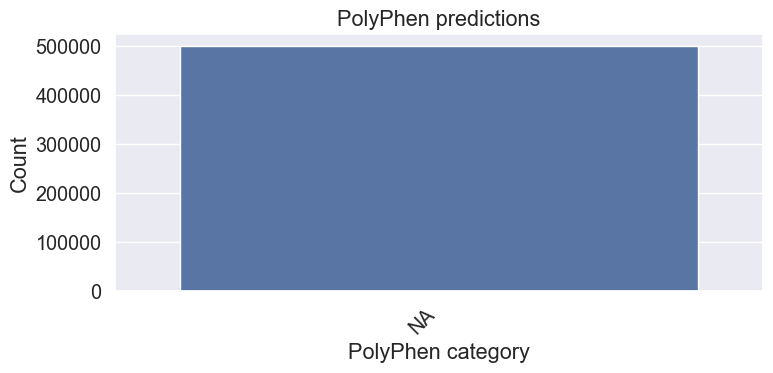

PolyPhen
NA    500000
Name: count, dtype: int64

CLASS,0,1,All
PolyPhen,,,
,445320,54680,500000
All,445320,54680,500000


In [25]:
# --------------------------------------------------
# 11. PolyPhen categories
# --------------------------------------------------
if "PolyPhen" in df.columns:
    poly_counts = (
        df["PolyPhen"]
        .replace("", np.nan)
        .fillna("NA")
        .value_counts()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(8, 4))
    sns.barplot(x=poly_counts.index, y=poly_counts.values)
    plt.xlabel("PolyPhen category")
    plt.ylabel("Count")
    plt.title("PolyPhen predictions")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    display(poly_counts)

    poly_class = pd.crosstab(df["PolyPhen"], df["CLASS"], margins=True)
    poly_class = poly_class.sort_values("All", ascending=False)
    display(poly_class)
else:
    print("No PolyPhen column found.")


AF columns found: ['AF_ESP', 'AF_EXAC', 'AF_TGP']


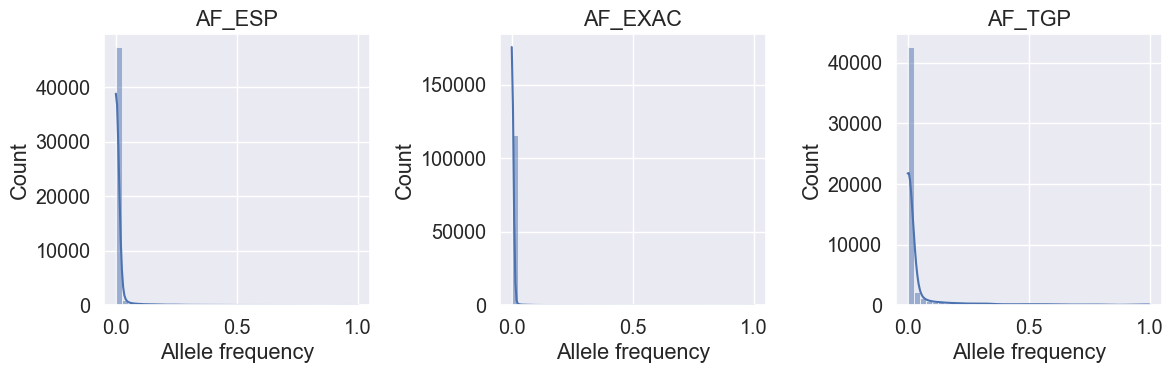

,count,mean,std,min,25%,50%,75%,max
AF_ESP,51302.0,0.021553,0.102750,0.00008,0.00008,0.00015,0.00120,0.99985
AF_EXAC,119039.0,0.008500,0.066847,0.00000,0.00001,0.00003,0.00011,1.00000
AF_TGP,53565.0,0.060545,0.168307,0.00000,0.00020,0.00100,0.01398,1.00000


In [26]:
# --------------------------------------------------
# 12. Allele frequency histograms (AF_ESP / AF_EXAC / AF_TGP)
# --------------------------------------------------
af_cols = ["AF_ESP", "AF_EXAC", "AF_TGP"]
af_cols = [c for c in af_cols if c in df.columns]

print("AF columns found:", af_cols)

if af_cols:
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(af_cols, 1):
        plt.subplot(1, len(af_cols), i)
        sns.histplot(df[col].dropna(), bins=40, kde=True)
        plt.title(col)
        plt.xlabel("Allele frequency")
    plt.tight_layout()
    plt.show()

    display(df[af_cols].describe().T)
else:
    print("No AF_* columns found.")


Numeric columns used for correlation: ['POS', 'CLASS', 'AF_ESP', 'AF_EXAC', 'AF_TGP']


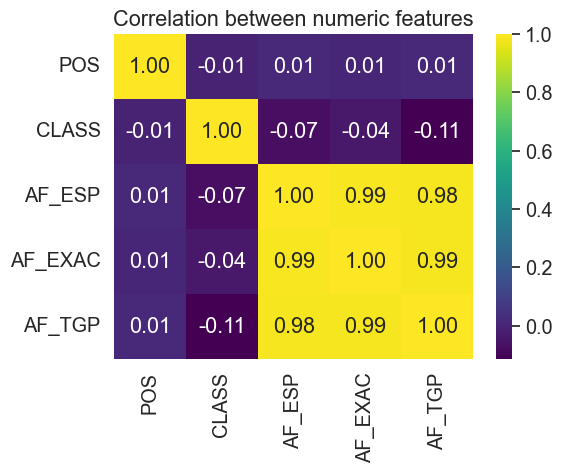

In [27]:
# --------------------------------------------------
# 13. Correlation heatmap of numeric features
# --------------------------------------------------
num_cols = ["POS", "CLASS", "AF_ESP", "AF_EXAC", "AF_TGP"]
num_cols = [c for c in num_cols if c in df.columns]

print("Numeric columns used for correlation:", num_cols)

if num_cols:
    corr = df[num_cols].corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis")
    plt.title("Correlation between numeric features")
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns for correlation.")


## **Analysis of the reference genome (ref)**

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

# Make sure ref and chrom_ids exist from your previous cell
# ref = pyfaidx.Fasta(FA_FILE, rebuild=True)
# chrom_ids = sorted(ref.keys(), key=chrom_key)

chrom_stats = []

# Use chunking so we don't load entire chromosomes in memory at once
chunk_size = 1_000_000  # 1 Mb chunks

for chrom in chrom_ids:
    seq_len = len(ref[chrom])
    gc_count = 0

    for start in range(0, seq_len, chunk_size):
        end = min(seq_len, start + chunk_size)
        s = ref[chrom][start:end].seq.upper()
        gc_count += s.count("G") + s.count("C")

    gc_frac = gc_count / seq_len if seq_len > 0 else 0.0

    chrom_stats.append({
        "CHROM": chrom,
        "length_bp": seq_len,
        "GC_fraction": gc_frac,
    })

chrom_df = pd.DataFrame(chrom_stats)
display(chrom_df)

print("\nTotal genome length (sum):", f"{chrom_df['length_bp'].sum():,} bp")
print("Mean GC fraction:", chrom_df["GC_fraction"].mean())


,CHROM,length_bp,GC_fraction
0,1,248956422,0.386279
1,2,242193529,0.399553
2,3,198295559,0.396266
3,4,190214555,0.381506
4,5,181538259,0.394469
5,6,170805979,0.394366
6,7,159345973,0.406015
7,8,145138636,0.400541
8,9,138394717,0.363240
9,10,133797422,0.413756



Total genome length (sum): 3,088,286,401 bp
Mean GC fraction: 0.3871917192830087


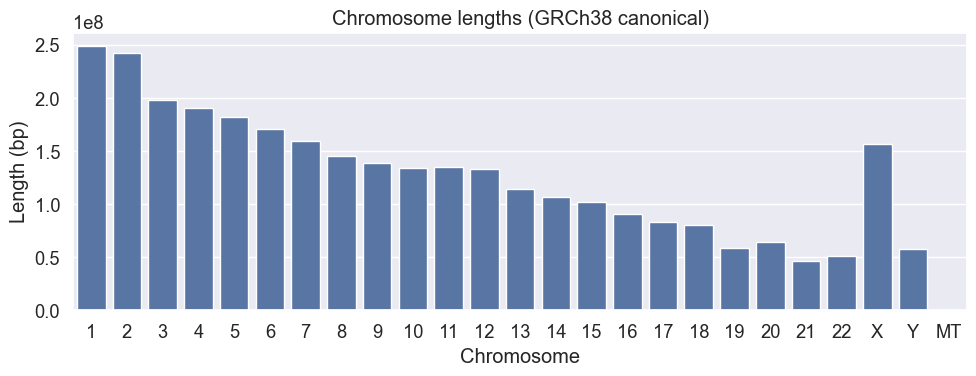

In [34]:
# --- Plot chromosome lengths ---
plt.figure(figsize=(10, 4))
sns.barplot(data=chrom_df, x="CHROM", y="length_bp")
plt.ylabel("Length (bp)")
plt.xlabel("Chromosome")
plt.title("Chromosome lengths (GRCh38 canonical)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## **Analysis of the sequence windows (X, y)**

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

print("X.shape:", X.shape)   # (N, 4, 201)
print("y.shape:", y.shape)
print("Pathogenic fraction (y==1):", y.mean())

# Check class counts
unique, counts = np.unique(y, return_counts=True)
print("Class counts:", dict(zip(unique, counts)))


X.shape: (500000, 4, 201)
y.shape: (500000,)
Pathogenic fraction (y==1): 0.10936
Class counts: {0: 445320, 1: 54680}


A: count=24,676,694  freq=0.246
C: count=25,392,876  freq=0.253
G: count=25,654,323  freq=0.255
T: count=24,776,107  freq=0.247


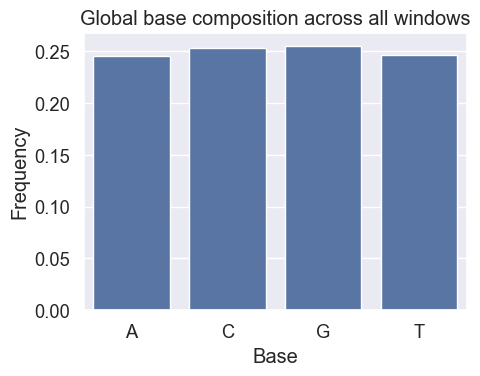

In [36]:
# --------------------------------------------------
# 1. Global base composition (A, C, G, T)
# --------------------------------------------------
N, C, W = X.shape
bases = ["A", "C", "G", "T"]

global_counts = X.sum(axis=(0, 2))  # sum over samples and positions → (4,)
global_freqs = global_counts / global_counts.sum()

for b, c, f in zip(bases, global_counts, global_freqs):
    print(f"{b}: count={int(c):,}  freq={f:.3f}")

plt.figure(figsize=(5, 4))
sns.barplot(x=bases, y=global_freqs)
plt.ylabel("Frequency")
plt.xlabel("Base")
plt.title("Global base composition across all windows")
plt.tight_layout()
plt.show()


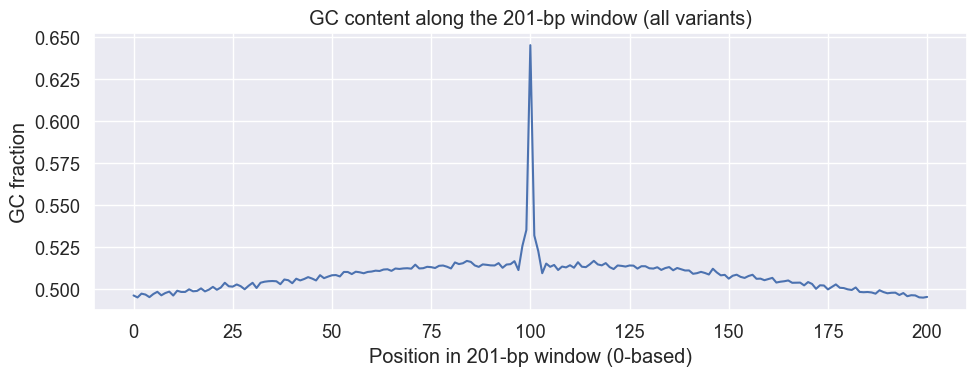

In [37]:
# --------------------------------------------------
# 2. Position-wise GC content across all windows
# --------------------------------------------------
# Channel indices from your one_hot_encode: A=0, C=1, G=2, T=3
C_channel = 1
G_channel = 2

gc_per_pos = (X[:, C_channel, :] + X[:, G_channel, :]).mean(axis=0)  # shape (W,)

plt.figure(figsize=(10, 4))
plt.plot(range(W), gc_per_pos)
plt.xlabel("Position in 201-bp window (0-based)")
plt.ylabel("GC fraction")
plt.title("GC content along the 201-bp window (all variants)")
plt.tight_layout()
plt.show()


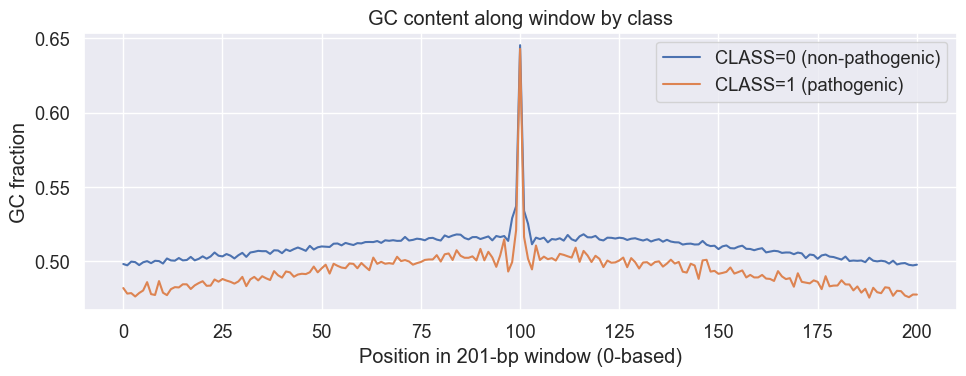

In [38]:
# --------------------------------------------------
# 3. GC content profile by class (0 vs 1)
# --------------------------------------------------
mask_path = (y == 1)
mask_non  = (y == 0)

gc_pos_path = (X[mask_path, C_channel, :] + X[mask_path, G_channel, :]).mean(axis=0)
gc_pos_non  = (X[mask_non,  C_channel, :] + X[mask_non,  G_channel, :]).mean(axis=0)

plt.figure(figsize=(10, 4))
plt.plot(range(W), gc_pos_non,  label="CLASS=0 (non-pathogenic)")
plt.plot(range(W), gc_pos_path, label="CLASS=1 (pathogenic)")
plt.xlabel("Position in 201-bp window (0-based)")
plt.ylabel("GC fraction")
plt.title("GC content along window by class")
plt.legend()
plt.tight_layout()
plt.show()


Center position (index 100 ) base frequencies:
A: count=88,981  freq=0.178
C: count=162,365  freq=0.325
G: count=160,188  freq=0.320
T: count=88,466  freq=0.177


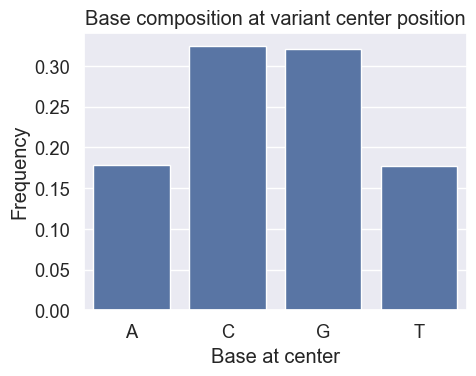

In [39]:
# --------------------------------------------------
# 4. Center-position base distribution (the variant position)
# --------------------------------------------------
center_idx = W // 2   # should be 100 for width=201

center_counts = X[:, :, center_idx].sum(axis=0)  # (4,)
center_freqs = center_counts / center_counts.sum()

print("Center position (index", center_idx, ") base frequencies:")
for b, c, f in zip(bases, center_counts, center_freqs):
    print(f"{b}: count={int(c):,}  freq={f:.3f}")

plt.figure(figsize=(5, 4))
sns.barplot(x=bases, y=center_freqs)
plt.ylabel("Frequency")
plt.xlabel("Base at center")
plt.title("Base composition at variant center position")
plt.tight_layout()
plt.show()


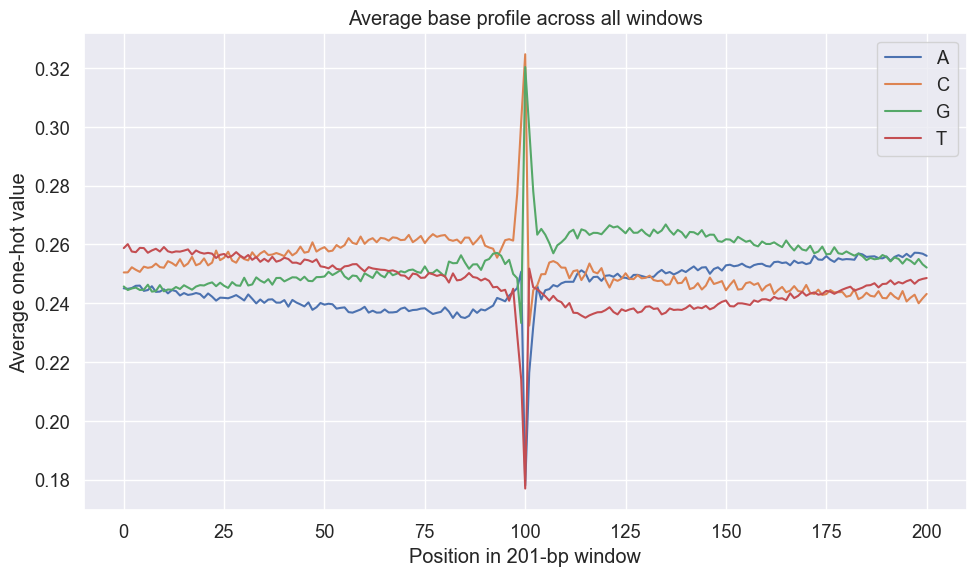

In [40]:
# --------------------------------------------------
# 5. Simple check: average one-hot per channel (like a motif logo summary)
# --------------------------------------------------
avg_profile = X.mean(axis=0)  # shape (4, W)

plt.figure(figsize=(10, 6))
for i, base in enumerate(bases):
    plt.plot(range(W), avg_profile[i, :], label=base)

plt.xlabel("Position in 201-bp window")
plt.ylabel("Average one-hot value")
plt.title("Average base profile across all windows")
plt.legend()
plt.tight_layout()
plt.show()
